In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
import csv

In [2]:
def lowpass_filter(audio_signal, sr, cutoff=150, order=5):
    """
    Áp dụng bộ lọc thông thấp Butterworth cho tín hiệu âm thanh
    
    Tham số:
        audio_signal: mảng numpy chứa tín hiệu âm thanh
        sr: tần số lấy mẫu (sample rate)
        cutoff: tần số cắt (Hz)
        order: bậc của bộ lọc
        
    Trả về:
        filtered_signal: tín hiệu đã lọc
    """
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.lfilter(b, a, audio_signal)
    return filtered_signal

<class 'numpy.ndarray'>
(661794,)


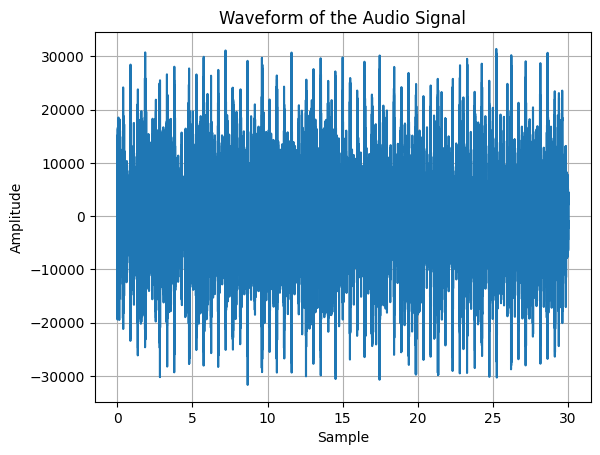

In [3]:
file_path = 'D:/Documents/PTIT/XLTHS-HOCLAI/music-similar/songs/disco.00044.wav'
# file_path = 'D:/Documents/PTIT/XLTHS-HOCLAI/music-similar/gia-nhu-30s.wav'
sr, data = wavfile.read(file_path)
print(type(data))
print(data.shape)

t = np.arange(data.shape[0])/sr
plt.plot(t,data)
plt.title("Waveform of the Audio Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

with open("output_1.txt", "w") as f:
    for item in data:
        f.write(f"{item}\n")

<class 'numpy.ndarray'>
(661794,)


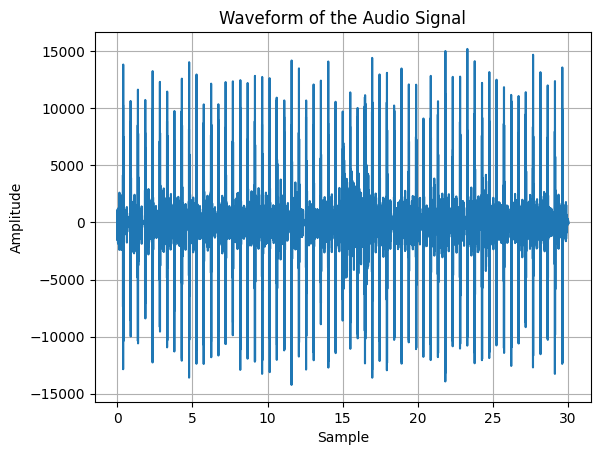

In [4]:
data = lowpass_filter(data, sr, 120)
print(type(data))
print(data.shape)

t = np.arange(data.shape[0])/sr
plt.plot(t,data)
plt.title("Waveform of the Audio Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

with open("output_2.txt", "w") as f:
    for item in data:
        f.write(f"{item}\n")

In [5]:

def frame_signal(signal, frame_size=512, hop_size=256):
    """
    Chia tín hiệu thành các khung nhỏ
    
    Tham số:
        signal: mảng numpy chứa tín hiệu âm thanh
        frame_size: kích thước khung
        hop_size: khoảng cách giữa các khung liên tiếp
        
    Trả về:
        frames: ma trận chứa các khung
    """
    n_frames = 1 + (len(signal) - frame_size) // hop_size
    frames = np.zeros((n_frames, frame_size))
    
    for i in range(n_frames):
        frames[i] = signal[i * hop_size : i * hop_size + frame_size]
    
    return frames

def compute_energy(frames):
    """
    Tính năng lượng trung bình của từng khung
    
    Tham số:
        frames: ma trận chứa các khung tín hiệu
        
    Trả về:
        energy: mảng chứa năng lượng của từng khung
    """
    # Tính năng lượng bằng phương pháp RMS (Root Mean Square)
    return np.sqrt(np.mean(frames**2, axis=1))

def normalize_signal(signal):
    """
    Chuẩn hóa tín hiệu về khoảng [-1, 1]
    
    Tham số:
        signal: mảng numpy chứa tín hiệu âm thanh
        
    Trả về:
        normalized_signal: tín hiệu đã chuẩn hóa
    """
    return signal / (np.max(np.abs(signal)) + 1e-10)

def autocorrelation(signal):
    """
    Tính hàm tự tương quan của tín hiệu
    
    Tham số:
        signal: mảng numpy chứa tín hiệu âm thanh
        
    Trả về:
        corr: hàm tự tương quan
    """
    # Chuẩn hóa tín hiệu
    signal = signal - np.mean(signal)
    
    # Tính autocorrelation
    result = np.correlate(signal, signal, mode='full')
    
    # Chỉ lấy nửa dương (cộng với điểm giữa)
    return result[result.size // 2:]

def tempo_estimate(wav_file_path, plot=False, min_bpm=40, max_bpm=220):
    """
    Ước lượng tempo (BPM) từ file WAV
    
    Tham số:
        wav_file_path: đường dẫn đến file WAV
        plot: True nếu muốn hiển thị biểu đồ kết quả
        min_bpm: giới hạn dưới của BPM
        max_bpm: giới hạn trên của BPM
        
    Trả về:
        bpm: tempo ước lượng (BPM)
    """
    # Đọc file âm thanh
    sr, audio_signal = wavfile.read(wav_file_path)
    
    # Chuẩn hóa tín hiệu về khoảng [-1, 1]
    if audio_signal.dtype == np.int16:
        audio_signal = audio_signal.astype(np.float32) / 32768.0
        
    # Áp dụng bộ lọc dải thông từ 20-150Hz để tập trung vào vùng tần số của kick/bass
    filtered_signal = lowpass_filter(audio_signal, sr, 120)
    
    # Chia tín hiệu thành các khung
    frame_size = 512  # khoảng 23ms với sr=22050
    hop_size = 256    # 50% overlap
    frames = frame_signal(filtered_signal, frame_size, hop_size)
    
    # Tính năng lượng của từng khung
    energy = compute_energy(frames)
    
    # Làm mịn đường năng lượng với bộ lọc thông thấp
    energy_smooth = lowpass_filter(energy, sr / hop_size, 5)
    
    # Chuẩn hóa năng lượng
    energy_smooth = normalize_signal(energy_smooth)
    
    # Tính autocorrelation
    corr = autocorrelation(energy_smooth)
    
    # Tìm các đỉnh trong hàm tự tương quan
    # Bỏ qua các đỉnh ở đầu (tương ứng với tempo quá cao)
    min_lag = int(sr / hop_size * 60 / max_bpm)  # Giới hạn 220 BPM
    max_lag = int(sr / hop_size * 60 / min_bpm)   # Giới hạn 40 BPM
    
    # Giới hạn phạm vi tìm kiếm
    corr_trim = corr[min_lag:max_lag]
    
    # Tìm đỉnh cao nhất
    peaks, _ = signal.find_peaks(corr_trim, height=0)
    
    if len(peaks) == 0:
        return 60.0  # Trả về giá trị mặc định nếu không tìm thấy đỉnh
    
    # Lấy đỉnh cao nhất
    peak_heights = corr_trim[peaks]
    strongest_peak_idx = peaks[np.argmax(peak_heights)]
    
    # Tính lag thực (vị trí đỉnh + vị trí bắt đầu tìm kiếm)
    lag_samples = strongest_peak_idx + min_lag
    
    # Tính thời gian tương ứng với lag này
    lag_time = lag_samples * hop_size / sr
    
    # Tính BPM
    bpm = 60.0 / lag_time
    
    # Vẽ biểu đồ nếu cần
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot tín hiệu gốc
        plt.subplot(4, 1, 1)
        t = np.arange(len(audio_signal)) / sr
        plt.plot(t, audio_signal)
        plt.title("Tín hiệu gốc")
        plt.xlabel("Thời gian (s)")
        
        # Plot tín hiệu đã lọc
        plt.subplot(4, 1, 2)
        t_filter = np.arange(len(filtered_signal)) / sr
        plt.plot(t_filter, filtered_signal)
        plt.title("Tín hiệu sau khi lọc dải thông thấp 150Hz")
        plt.xlabel("Thời gian (s)")
        
        # Plot năng lượng
        plt.subplot(4, 1, 3)
        t_energy = np.arange(len(energy_smooth)) * hop_size / sr
        plt.plot(t_energy, energy_smooth)
        plt.title("Đường bao năng lượng")
        plt.xlabel("Thời gian (s)")
        
        # Plot autocorrelation và đánh dấu đỉnh
        plt.subplot(4, 1, 4)
        t_corr = np.arange(len(corr)) * hop_size / sr
        plt.plot(t_corr[:max_lag], corr[:max_lag])
        plt.axvline(x=lag_time, color='r', linestyle='--')
        plt.text(lag_time + 0.1, 0.5, f"{bpm:.1f} BPM", color='r')
        plt.title("Hàm tự tương quan")
        plt.xlabel("Độ trễ (s)")
        
        plt.tight_layout()
        plt.show()
    
    return bpm

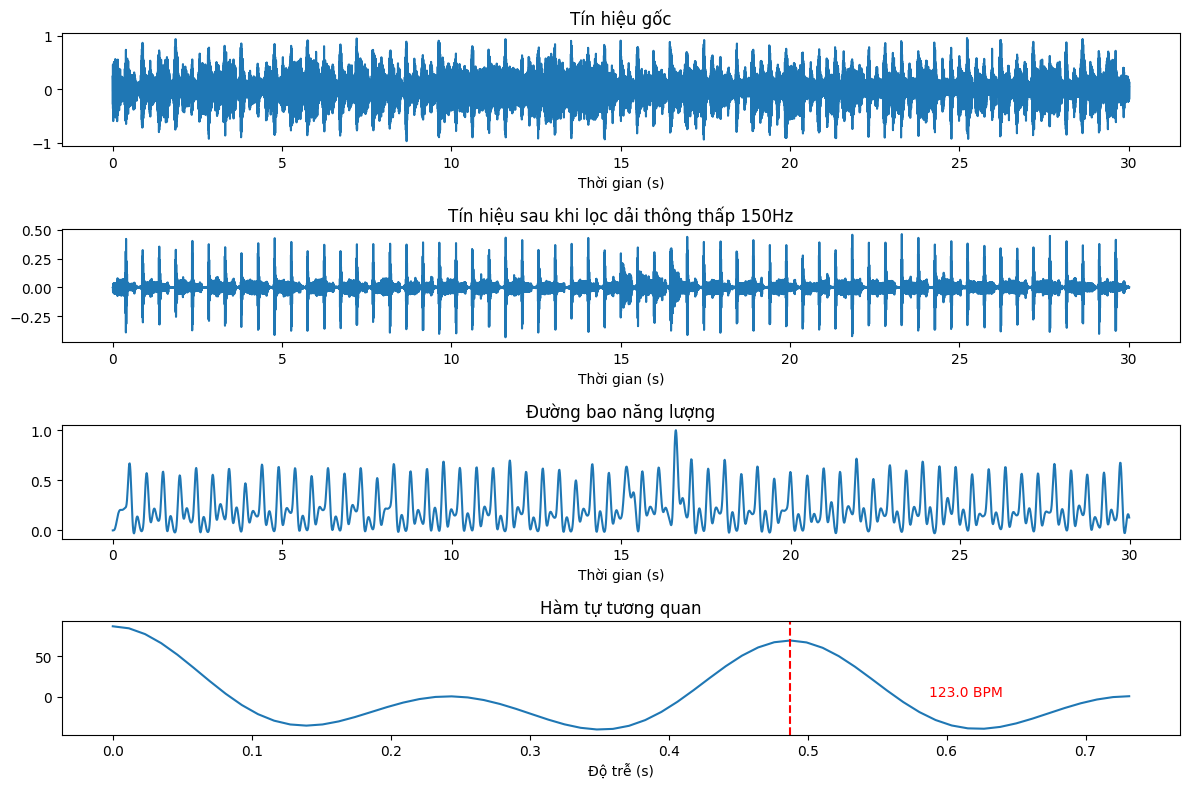

In [6]:
tempo = tempo_estimate(file_path, True, 80, 150)

In [7]:

def extract_features(wav_path, bpm):
    """
    Trích xuất các đặc trưng âm thanh từ file WAV dựa trên BPM.
    
    Parameters:
    -----------
    wav_path : str
        Đường dẫn đến file WAV (mono, 22050Hz, 16-bit)
    bpm : float
        Tempo của bài hát (BPM)
        
    Returns:
    --------
    None
        Lưu các đặc trưng vào file features.csv
    """
    # Đọc file WAV
    sampling_rate, audio_data = wavfile.read(wav_path)
    
    # Chuyển đổi sang kiểu float để xử lý
    if audio_data.dtype == np.int16:
        audio_data = audio_data.astype(np.float32) / 32768.0  # Chuẩn hóa về [-1, 1]
    
    # Tính toán độ dài của frame dựa trên BPM
    # 1 bar = 4 beats
    bar_duration = 60 / bpm * 4  # tính bằng giây
    frame_length = int(bar_duration * sampling_rate)
    hop_size = frame_length // 2  # 50% overlap
    
    # Chuẩn bị đặc trưng
    features = []
    
    # Xử lý từng frame
    for frame_index, i in enumerate(range(0, len(audio_data) - frame_length + 1, hop_size)):
        frame = audio_data[i:i + frame_length]
        start_time = i / sampling_rate  # Thời điểm bắt đầu của frame (giây)
        
        # RMS energy
        rms = np.sqrt(np.mean(frame ** 2))
        
        # Average Energy
        avg_energy = np.mean(frame ** 2)
        
        # Zero-Crossing Rate
        zcr = np.sum(np.abs(np.diff(np.signbit(frame)))) / len(frame)
        
        # Tính toán phổ (magnitude spectrum)
        spectrum = np.abs(fft(frame))
        spectrum = spectrum[:frame_length // 2 + 1]  # Lấy nửa đầu (phổ dương)
        
        # Tạo vector tần số
        frequencies = np.linspace(0, sampling_rate // 2, len(spectrum))
        
        # Tính tổng phổ (để chuẩn hóa)
        total_spectrum = np.sum(spectrum)
        if total_spectrum == 0:
            # Tránh chia cho 0
            centroid = 0
            bandwidth = 0
            rolloff = 0
        else:
            # Spectral Centroid
            centroid = np.sum(frequencies * spectrum) / total_spectrum
            
            # Spectral Bandwidth (độ lệch chuẩn xung quanh centroid)
            bandwidth = np.sqrt(np.sum(((frequencies - centroid) ** 2) * spectrum) / total_spectrum)
            
            # Spectral Rolloff (85%)
            threshold = 0.85 * total_spectrum
            cumsum_spectrum = np.cumsum(spectrum)
            rolloff_idx = np.where(cumsum_spectrum >= threshold)[0][0]
            rolloff = frequencies[rolloff_idx]
        
        # Lưu các đặc trưng cho frame hiện tại
        features.append([
            frame_index,        # Chỉ số frame
            start_time,         # Thời điểm bắt đầu (giây)
            rms,                # RMS energy
            zcr,                # Zero-Crossing Rate
            centroid,           # Spectral Centroid
            bandwidth,          # Spectral Bandwidth
            rolloff,            # Spectral Rolloff
            avg_energy          # Average Energy
        ])
    
    # Lưu các đặc trưng vào file CSV
    with open('features.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Viết header
        writer.writerow(['frame_index', 'start_time', 'rms', 'zcr', 'centroid', 
                         'bandwidth', 'rolloff', 'avg_energy'])
        # Viết dữ liệu
        writer.writerows(features)
    
    print(f"Đã trích xuất {len(features)} frames và lưu vào features.csv")
    return features

In [8]:
extract_features(file_path, tempo)

Đã trích xuất 29 frames và lưu vào features.csv


[[0,
  0.0,
  np.float32(0.15833376),
  np.float64(0.12062872023809523),
  np.float64(2556.295094126684),
  np.float64(2642.296013223834),
  np.float64(5292.041015625),
  np.float32(0.02506958)],
 [1,
  0.9752380952380952,
  np.float32(0.15850031),
  np.float64(0.11839657738095238),
  np.float64(2639.9504589133467),
  np.float64(2645.7949753868356),
  np.float64(5475.5859375),
  np.float32(0.02512235)],
 [2,
  1.9504761904761905,
  np.float32(0.1605489),
  np.float64(0.11507161458333333),
  np.float64(2626.342556051923),
  np.float64(2642.7992203507297),
  np.float64(5458.6669921875),
  np.float32(0.025775947)],
 [3,
  2.9257142857142857,
  np.float32(0.15174113),
  np.float64(0.11474609375),
  np.float64(2663.7671095987043),
  np.float64(2681.00172521711),
  np.float64(5553.0029296875),
  np.float32(0.023025371)],
 [4,
  3.900952380952381,
  np.float32(0.16231465),
  np.float64(0.10884021577380952),
  np.float64(2575.9954667322486),
  np.float64(2653.599425460141),
  np.float64(5370.9